Importing Libraries

In [1]:
import cv2 as cv
from google.colab import drive
import os
import numpy as np
from matplotlib import pyplot as plt
import random
from sklearn.utils import shuffle

Load Data from Google drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_set = '/content/drive/MyDrive/Birds_dataset/train'
test_set = '/content/drive/MyDrive/Birds_dataset/test'
valid_set = '/content/drive/MyDrive/Birds_dataset/valid'

In [4]:
classes_train = os.listdir(train_set)

In [5]:
classes_valid = os.listdir(valid_set)

In [6]:
classes_test= os.listdir(test_set)

Splitting Datasets to X, y

In [7]:
#Training Set
train_images = []
train_labels = []
for i in classes_train:
    images_1 = os.listdir(train_set + '/' + i)
    for img in images_1:
        train_images.append(cv.imread(train_set + '/' + i + '/' +img))
        train_labels.append(i)
print(len(train_images), len(train_labels))

58398 58398


In [8]:
#Shuffle the images in training set

train_images, train_labels = shuffle(train_images, train_labels)

In [9]:
#Validation Set
valid_images = []
valid_labels = []
for i in classes_valid:
    images_2 = os.listdir(valid_set + '/' + i)
    for img in images_2:
        valid_images.append(cv.imread(train_set + '/' + i + '/' +img))
        valid_labels.append(i)
print(len(valid_images), len(valid_labels))

2000 2000


In [10]:
#Shuffle the images in validation set

valid_images, valid_labels = shuffle(valid_images, valid_labels)

Image Augementation

In [11]:
#Image_Translation
def translation(image):
  height, width = image.shape[:2]
  quarter_height, quarter_width = height/4, width/4
  T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
  translated = cv.warpAffine(image, T, (width, height))
  return translated

In [12]:
#Image_Rotation
def rotation(image):
  height, width = image.shape[:2]
  r = cv.getRotationMatrix2D((height/2, width/2), 30, 1)
  rotated = cv.warpAffine(image, r, (width, height))
  return rotated

In [13]:
#Image_Flip
def flip(image):
  flipped = cv.flip(image, 1) # 1 vertical & 0 Horizntal
  return flipped

In [14]:
def agumented_image(image,label):
  if np.random.rand()<0.5:
    image=rotation(image)
  if np.random.rand()<0.5:
    image=translation(image)
  if np.random.rand()<0.5:
    image=flip(image)
    
  return image,label

Visualize the Augmented Images

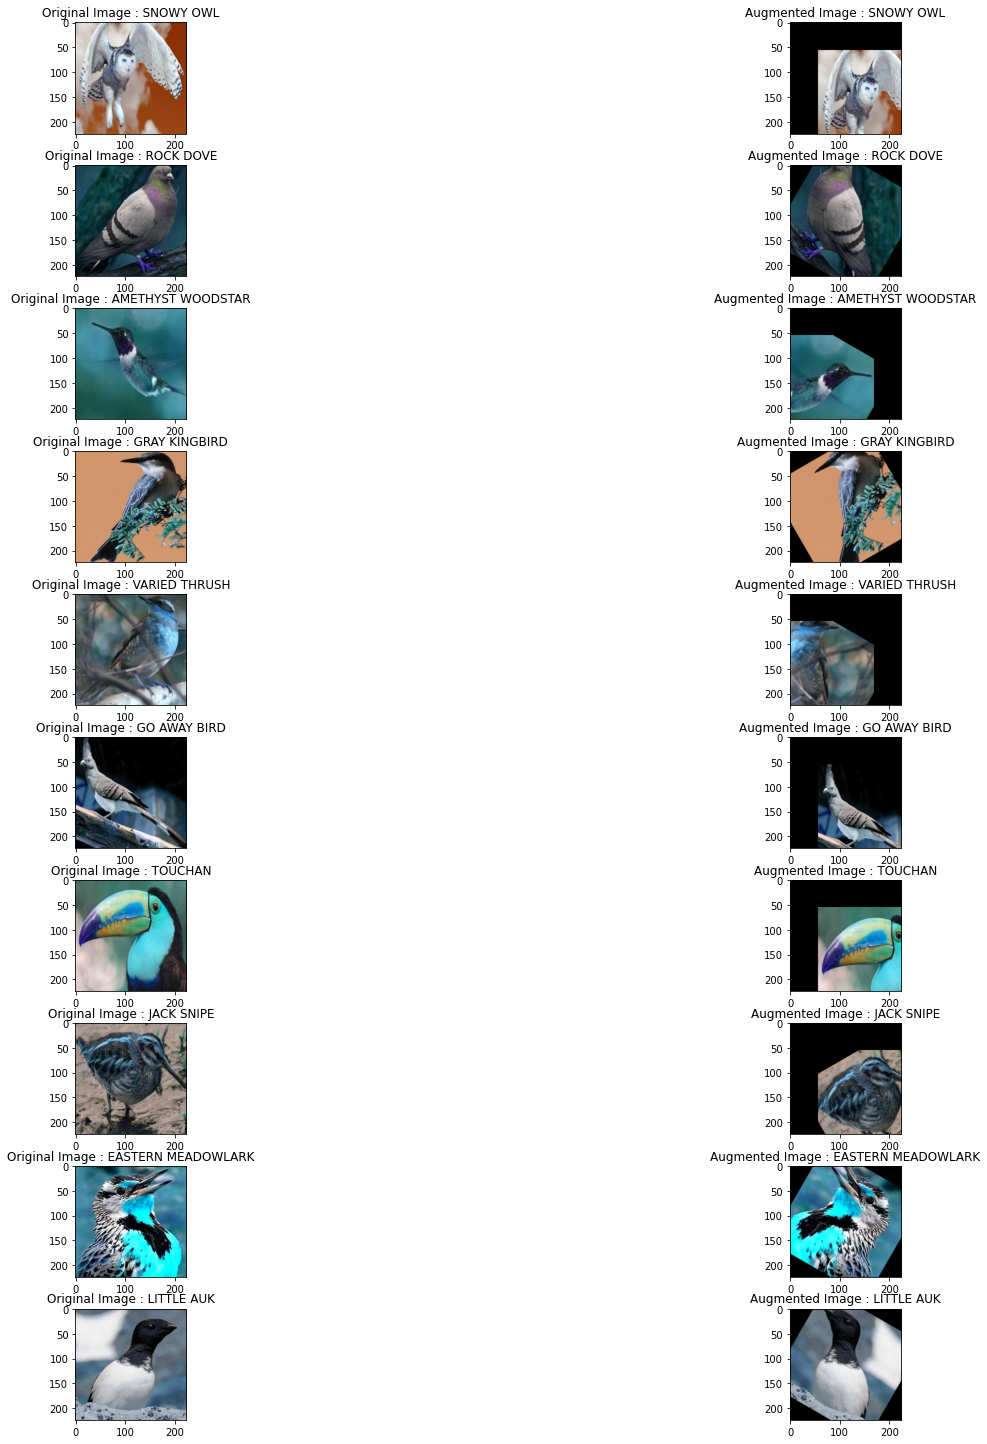

In [15]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(20, 20))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(train_images) - 1)
  random_image = train_images[randnum]
    
  original_image =random_image
  augmented_image, label = agumented_image(random_image,train_labels[randnum])
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image : "+ str(label))
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image : " +str(label))

Preprocessing

In [16]:
#Getting the shape of the images
print(train_images[0].shape,train_images[1].shape)

(224, 224, 3) (224, 224, 3)


In [17]:
# Getting the Mean of the Dimensions of the images to resize them
dim_1 = []
dim_2 = []
for i in train_images:
  d1, d2 = i.shape[:2]
  dim_1.append(d1)
  dim_2.append(d2)
mean_1 = np.mean(dim_1)
mean_2 = np.mean(dim_2)
print(mean_1, mean_2)

224.0 224.0


Applying Transfere learning using ResNet50


In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential, Model

model = ResNet50(include_top = False, weights='imagenet', input_shape= (224, 224, 3))


In [19]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
def creat_model(input_shape = (224,224, 3), n_classes = 400, optimizer = 'adam'):
  base = ResNet50(include_top = False, weights='imagenet', input_shape= input_shape)
  for layer in base.layers:
    layer.trainable = False
  
  top_model = base.output
  top_model = Flatten(name = 'flatter')(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(2050, activation='relu')(top_model)
  top_model = Dropout(0.25)(top_model)
  top_model = Dense(1025, activation='relu')(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)

  model = Model(inputs = base.inputs, outputs = output_layer)

  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
final_model = creat_model()
final_model.summary()

Fit the model to the training sets

In [ ]:
history = final_model.fit(train_images, train_labels, epochs=2, batch_size = 2500, validation_data=(valid_images,valid_labels))

In [22]:
model.save('Birds_Categories.h5')